In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from polModel import PolModel
from draine_dust_2D import draine_dust
from model_spec import model_spec

In [2]:
#General plotting function
def pol_plot(mod_p, spec):

    data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    p_measured = data[:,0]
    p_unc = data[:,1]

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    for scat_type in mod_p.keys():
        ax.plot(wave, mod_p[scat_type], 's', label=scat_type)

    ax.legend()
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Model the SDSS Spectrum

In [3]:
spec, model = model_spec()

### Pure Gas Models.

In [6]:
#Define the object
class Gas_Gas(object):
    def get_pfrac(self, lam_rest):
        return np.ones(len(lam_rest))
    def get_pfrac_A(self, x, lam_rest):
        return self.get_pfrac(lam_rest)
    def get_pfrac_B(self, x, lam_rest):
        return self.get_pfrac(lam_rest)

In [7]:
#Set the objects
scat_obj = Gas_Gas()
pol_model = PolModel(spec, model)

#Run the fits
x0 = np.array([0.15, 0.15, 45.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([1., 1., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals)
print(pol_model.xopt)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.1129775751895208e-08
       x: [ 1.148e-01  3.204e-01  4.478e+01]
     nit: 15
     jac: [-7.613e-02 -2.179e-04  5.111e-05]
    nfev: 68
    njev: 15


In [8]:
xopt_all = dict()
mod_p_all = dict()
xopt_all["Gas"] = pol_model.xopt
mod_p_all["Gas"] = pol_model.mod_p

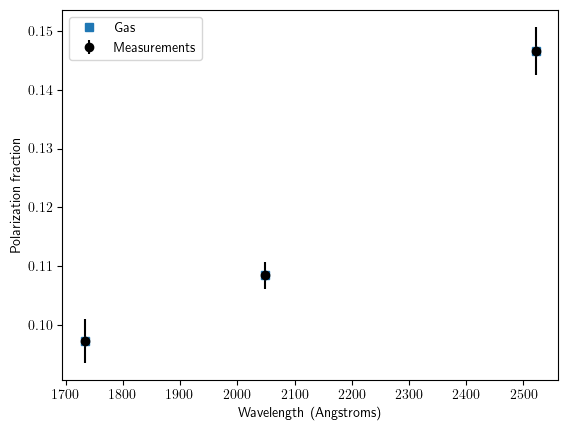

In [9]:
pol_plot(mod_p_all, spec)

### Pure Dust Models.

In [10]:
#Define the object.
class Dust_Dust(object):

    def __init__(self, dust_type):
        #Load the dust model. 
        self.dust = draine_dust(dust_type)
        return

    def get_pfrac(self, x, lam_rest):
        phi = x[3]
        return self.dust.pfrac(lam_rest.to(u.um).value, phi).flatten()
    
    def get_pfrac_A(self, x, lam_rest):
        return self.get_pfrac(x, lam_rest)
    
    def get_pfrac_B(self, x, lam_rest):
        return self.get_pfrac(x, lam_rest)



In [11]:
dust_types = ["SMC", "LMC", "MW"]

In [12]:
for dust_type in dust_types:
    #Set the objects
    scat_obj = Dust_Dust(dust_type)

    #Run the fits. Attempt a start with scattering angle < 90. and > 90.
    x0 = np.array([0.9, 0.3, 45., 90.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([1., 1., 90., 180.])
    for i in range(2):
        if i==0:
            x0[-1] = 60.
        else:
            x0[-1] = 170.
        pol_model_aux = PolModel(spec, model)
        pol_model_aux.fit_pol(scat_obj, x0, min_vals, max_vals)
        if i==0 or pol_model_aux.xopt.fun < pol_model.xopt.fun:
            pol_model = pol_model_aux

    print(pol_model.xopt)

    #Save the results.
    xopt_all["DD_"+dust_type] = pol_model.xopt
    mod_p_all["DD_"+dust_type] = pol_model.mod_p



 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.5732654549947114e-09
       x: [ 8.783e-01  9.921e-01  7.557e+01  7.870e+01]
     nit: 48
     jac: [ 6.766e-03 -1.305e-03 -8.795e-05  6.339e-05]
    nfev: 265
    njev: 48
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 164.85736893519032
       x: [ 1.000e+00  6.947e-01  9.000e+01  6.331e+01]
     nit: 18
     jac: [-5.320e+02 -2.439e-03 -1.335e-05  5.722e-05]
    nfev: 98
    njev: 18
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.0178225940890143e-08
       x: [ 9.588e-01  5.092e-01  9.000e+01  6.063e+01]
     nit: 24
     jac: [-1.482e-03  2.228e-04  0.000e+00 -7.317e-05]
    nfev: 128
    njev: 24


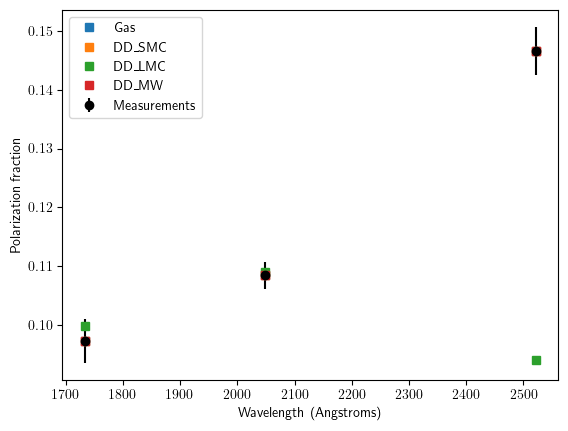

In [13]:
pol_plot(mod_p_all, spec)

### Dust for continuum, Gas for emission lines.

In [14]:
class Dust_Gas(Dust_Dust):

    def __init__(self, dust_type):
        #Load the dust model. 
        self.dust = draine_dust(dust_type)
        return

    def get_pfrac_A(self, x, lam_rest):
        phi = x[3]
        return self.dust.pfrac(lam_rest.to(u.um).value, phi).flatten()
    
    def get_pfrac_B(self, x, lam_rest):
        return np.ones(len(spec.lam_rest))

In [15]:
for dust_type in dust_types:
    #Set the objects
    scat_obj = Dust_Gas(dust_type)

    #Run the fits. Attempt a start with scattering angle < 90. and > 90.
    x0 = np.array([0.9, 0.5, 45., 90.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([1., 1., 90., 180.])
    for i in range(2):
        if i==0:
            x0[-1] = 60.
        else:
            x0[-1] = 170.
        pol_model_aux = PolModel(spec, model)
        pol_model_aux.fit_pol(scat_obj, x0, min_vals, max_vals)
        if i==0 or pol_model_aux.xopt.fun < pol_model.xopt.fun:
            pol_model = pol_model_aux

    print(pol_model.xopt)

    #Save the results.
    xopt_all["DG_"+dust_type] = pol_model.xopt
    mod_p_all["DG_"+dust_type] = pol_model.mod_p



 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.207360351326956
       x: [ 1.000e+00  4.304e-01  9.000e+01  1.075e+02]
     nit: 38
     jac: [-1.518e+01 -4.170e-02  0.000e+00 -8.357e-05]
    nfev: 208
    njev: 38
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 102.70432201209668
       x: [ 1.000e+00  5.631e-01  7.714e+01  8.331e+01]
     nit: 47
     jac: [-3.788e+02 -9.381e-03 -3.815e-04  1.535e-04]
    nfev: 260
    njev: 45
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 11.251755271716334
       x: [ 1.000e+00  7.596e-02  8.995e+01  5.289e+01]
     nit: 75
     jac: [-7.584e+00 -2.284e-01 -8.464e-06  2.981e-03]
    nfev: 399
    njev: 75


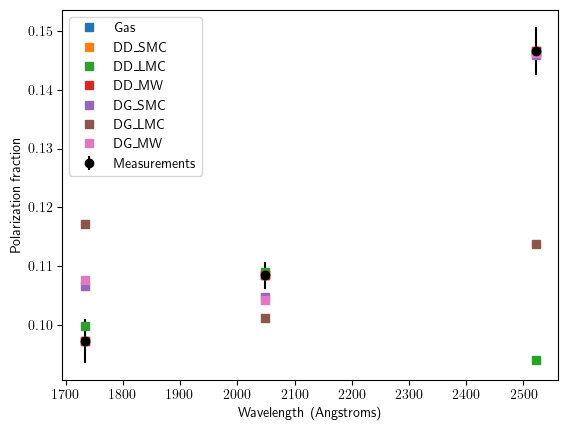

In [16]:
pol_plot(mod_p_all, spec)